<a href="https://colab.research.google.com/github/shell-done/Google-Codelabs/blob/main/TensorFlow/First_steps_with_tensor_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Premiers pas avec TensorFlow

 **Objectifs d'apprentissage :**
  * Concepts fondamentaux de TensorFlow
  * Utiliser la classe `LinearRegressor` de TensorFlow pour prédire le prix médian des logements, au niveau des îlots urbains, sur la base d'une seule caractéristique d'entrée
  * Évaluer la justesse des prédictions d'un modèle en utilisant la racine carrée de l'erreur quadratique moyenne (Root Mean Squared Error, RMSE)
  * Améliorer la justesse d'un modèle en modifiant ses hyperparamètres

 Les données sont basées sur le recensement de 1990 de l'État de Californie.

 ## Configuration
Dans cette première cellule, vous allez charger les bibliothèques nécessaires.

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

TensorFlow 1.x selected.


 Vous allez ensuite charger votre ensemble de données.

In [ ]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

 Vous allez mélanger les données de manière aléatoire, pour être sûr d'éviter les effets de classement pathologique pouvant nuire aux performances de la descente de gradient stochastique. Vous allez, en outre, mettre à l'échelle la valeur `median_house_value` pour qu'elle soit exprimée en milliers, de sorte que son apprentissage soit un peu plus facile avec des taux dans l'intervalle utilisé généralement.

In [ ]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
11749,-121.3,38.0,52.0,1938.0,332.0,788.0,320.0,3.6,118.4
604,-117.0,34.1,16.0,3784.0,577.0,1615.0,525.0,4.2,220.3
15149,-122.3,37.8,52.0,2097.0,444.0,915.0,413.0,3.0,228.1
10598,-120.5,34.6,14.0,885.0,223.0,533.0,224.0,2.6,109.3
1222,-117.1,32.7,38.0,1445.0,392.0,1286.0,357.0,1.5,80.2
...,...,...,...,...,...,...,...,...,...
14734,-122.2,37.8,49.0,1368.0,282.0,790.0,269.0,1.7,91.4
16845,-123.4,39.4,32.0,2780.0,470.0,1281.0,479.0,3.6,96.0
4834,-118.1,33.9,19.0,8120.0,1371.0,5026.0,1345.0,6.3,286.5
1474,-117.2,34.5,7.0,8414.0,1584.0,5146.0,1517.0,3.3,92.5


 ## Analyse des données

Il est conseillé de se familiariser avec les données avant de les exploiter.

Nous allons imprimer un bref résumé de quelques statistiques utiles sur chaque colonne : nombre d'exemples, moyenne, écart type, maximum, minimum et divers quantiles.

In [ ]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


 ## Construction du premier modèle

Dans cet exercice, vous allez essayer de prédire la valeur médiane d'un logement (`median_house_value`) qui deviendra l'étiquette (que l'on désigne parfois également sous le nom de cible). Vous utiliserez le nombre de pièces (`total_rooms`) comme caractéristique d'entrée.

**REMARQUE :** Les données se situent au niveau de l'îlot urbain. Cette caractéristique représente donc le nombre total de pièces dans cet îlot.

Pour entraîner le modèle, vous allez utiliser l'interface [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) fournie par l'API [Estimator](https://www.tensorflow.org/get_started/estimator) de TensorFlow. Cette API s'occupe d'une bonne partie des mécanismes sous-jacents du modèle de bas niveau, et propose des méthodes pratiques pour effectuer les tâches d'apprentissage du modèle, d'évaluation et d'inférence.

 ### Étape 1 : Définir les caractéristiques et configurer les colonnes de caractéristiques

 Pour qu'il soit possible d'importer les données d'apprentissage dans TensorFlow, vous devez spécifier le type de données qui se trouve dans chaque caractéristique. Vous utiliserez principalement deux types de données pour cet exercice et les suivants :

* **Données catégorielles** : il s'agit de données textuelles. L'ensemble de données immobilières utilisé dans cet exercice ne contient aucune caractéristique catégorielle. Ce type de données pourrait être le style de logement, le contenu d'une annonce immobilière…

* **Données numériques** : données représentant un nombre (entier ou à virgule flottante) et que vous souhaitez traiter comme tel. Comme nous le verrons par la suite, vous pouvez, dans certains cas, traiter des données numériques (un code postal, par exemple), comme si elles étaient de type catégoriel.

Dans TensorFlow, le type de données d'une caractéristique est indiqué à l'aide d'une construction appelée **colonne de caractéristiques**. Les colonnes de ce type ne stockent qu'une description des données de la caractéristique ; elles ne contiennent pas les données proprement dites.

Dans un premier temps, vous allez simplement utiliser une caractéristique d'entrée numérique, `total_rooms`. Le code suivant extrait les données `total_rooms` de l'ensemble `california_housing_dataframe` et définit la colonne de caractéristiques à l'aide de `numeric_column`, qui précise que ses données sont numériques :

In [14]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]
print(my_feature)

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

       total_rooms
11749       1938.0
604         3784.0
15149       2097.0
10598        885.0
1222        1445.0
...            ...
14734       1368.0
16845       2780.0
4834        8120.0
1474        8414.0
10506       2787.0

[17000 rows x 1 columns]


 **REMARQUE :** Les données `total_rooms` se présentent sous la forme d'un tableau à une seule dimension (une liste du nombre total de pièces pour chaque îlot urbain). Il s'agit de la forme par défaut pour `numeric_column`. Par conséquent, elle ne doit pas être transmise en tant qu'argument.

 ### Étape 2 : Définir la cible

 Vous allez ensuite définir la cible, à savoir la valeur médiane d'un logement (`median_house_value`). Ici encore, vous pouvez extraire cette donnée de l'ensemble `california_housing_dataframe` :

In [ ]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]

 ### Étape 3 : Configurer la classe LinearRegressor

 Vous allez ensuite configurer un modèle de régression linéaire à l'aide de LinearRegressor. Vous allez entraîner ce modèle à l'aide de `GradientDescentOptimizer`, qui met en œuvre une descente de gradient stochastique par mini-lots. L'argument `learning_rate` détermine la taille du pas de gradient.

**REMARQUE :** Par mesure de précaution, un [bornement de la norme du gradient] (https://developers.google.com/machine-learning/glossary/#gradient_clipping) est également appliqué à l'optimiseur via `clip_gradients_by_norm`. Le bornement de la norme du gradient permet de s'assurer que la magnitude des gradients reste dans des limites acceptables au cours de l'apprentissage, sans quoi la descente de gradient risque d'échouer. 

In [ ]:
# Use gradient descent as the optimizer for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

 ### Étape 4 : Définir la fonction d'entrée

 Pour importer les données immobilières de l'État de Californie dans `LinearRegressor`, une fonction d'entrée doit être définie. Cette fonction indique non seulement à TensorFlow comment effectuer le prétraitement des données, mais aussi comment les mettre en lots, les lire en mode aléatoire et les répéter pendant l'entraînement du modèle.

Vous allez, tout d'abord, convertir les données de la caractéristique *pandas* en un dictionnaire de tableaux NumPy. Vous pourrez ensuite utiliser l'[API Dataset] (https://www.tensorflow.org/programmers_guide/datasets) de TensorFlow pour construire un objet d'ensemble de données à partir de ces données, puis scinder ces dernières dans des lots de `batch_size`, de sorte qu'elles soient répétées pour le nombre indiqué d'itérations (num_epochs). 

**REMARQUE :** Lorsque la valeur par défaut de `num_epochs=None` est transmise à `repeat()`, les données d'entrée sont répétées indéfiniment.

Ensuite, si `shuffle` est défini sur `True`, les données seront lues de manière aléatoire, de façon à être transmises aléatoirement au modèle au cours de l'apprentissage. L'argument `buffer_size` indique la taille de l'ensemble de données à partir duquel `shuffle` sera échantillonné de manière aléatoire.

Pour terminer, la fonction d'entrée construit un itérateur pour l'ensemble de données et renvoie le lot de données suivant à LinearRegressor.

In [18]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 **REMARQUE :** Vous continuerez à utiliser cette fonction d'entrée dans les prochains exercices. Pour en savoir plus sur les fonctions d'entrée et l'API `Dataset`, consultez le [Guide du programmeur de TensorFlow] (en anglais) (https://www.tensorflow.org/programmers_guide/datasets).

 ### Étape 5 : Entraîner le modèle

 Vous pouvez maintenant appeler `train()` sur `linear_regressor` pour entraîner le modèle. Vous allez encapsuler `my_input_fn` dans un `lambda`
afin de pouvoir transmettre `my_feature` et `target` comme arguments (pour en savoir plus, reportez-vous à ce [didacticiel sur la fonction d'entrée TensorFlow](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model)). Pour commencer, vous allez effectuer
l'apprentissage pour 100 pas.

In [19]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

 ### Étape 6 : Évaluer le modèle

 Vous allez faire des prédictions sur les données d'apprentissage afin de déterminer dans quelle mesure elles sont adaptées à votre modèle au cours de l'apprentissage.

**REMARQUE :** L'erreur d'apprentissage mesure à quel point votre modèle est adapté aux données d'apprentissage. En revanche, elle ne mesure **_pas_** la qualité de **_généralisation du modèle aux nouvelles données_**. Au cours des prochains exercices, vous examinerez comment scinder les données afin d'évaluer la capacité de généralisation de votre modèle.


In [20]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56251.030
Root Mean Squared Error (on training data): 237.173


 S'agit-il d'un bon modèle ? Comment évaluer l'importance de l'erreur ?

Une erreur quadratique moyenne (MSE) pouvant être difficile à interpréter, on tient plutôt compte de la racine carrée de l'erreur quadratique
moyenne (RMSE). Une propriété intéressante de RMSE est la possibilité de l'interpréter sur la même échelle que les cibles d'origine.

Comparons la RMSE à la différence des valeurs minimale et maximale de nos cibles :

In [21]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.173


 L'erreur couvre pratiquement la moitié de l'intervalle des valeurs cibles. Peut-on faire mieux ?

C'est la question qui agace tous les développeurs de modèle. Élaborons quelques stratégies de base pour réduire l'erreur de modèle.

Pour commencer, vous pouvez examiner dans quelle mesure les prédictions répondent aux cibles qui ont été définies, en termes de statistiques récapitulatives globales.

In [22]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.4,207.3
std,0.3,116.0
min,0.0,15.0
25%,0.2,119.4
50%,0.3,180.4
75%,0.5,265.0
max,5.7,500.0


 Ces informations peuvent s'avérer bien utiles. Comment peut-on comparer la valeur moyenne à la valeur RMSE du modèle ? Qu'en est-il des divers quantiles ?

Vous pouvez également visualiser les données et la ligne qui a été apprise. Pour rappel, la régression linéaire sur une seule caractéristique peut être représentée par une droite transformant l'entrée *x* en la sortie *y*.

Vous allez d'abord obtenir un échantillon aléatoire uniforme des données, de manière à créer un diagramme de dispersion lisible.

In [23]:
sample = california_housing_dataframe.sample(n=300)

 Vous allez ensuite représenter, sous forme graphique, la ligne qui a été apprise, en partant de la pondération de caractéristique et du biais du modèle, superposée au diagramme de dispersion. La ligne sera affichée en rouge.

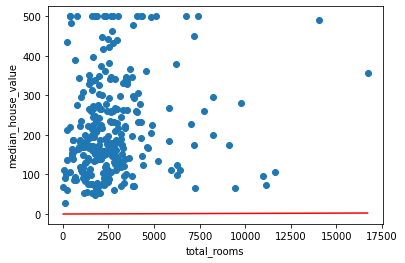

In [24]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

 Cette ligne initiale semble très éloignée. Voyez s'il est possible de revenir aux statistiques récapitulatives et d'examiner les mêmes informations qui y sont encodées.

Ces évaluations d'intégrité laissent supposer qu'il doit être possible de trouver une bien meilleure ligne

 ## Modifier les hyperparamètres du modèle
Dans le cadre de cet exercice, tout le code ci-dessus a été placé dans une seule fonction pour plus de facilité. Vous pouvez appeler cette fonction avec différents paramètres pour visualiser les effets.

Dans cette fonction, vous travaillerez dans 10 périodes réparties uniformément, afin de pouvoir observer l'amélioration du modèle à chaque période.

Pour chaque période, vous allez calculer et représenter graphiquement la perte d'apprentissage. Cela peut vous aider à déterminer si un modèle a convergé ou si des itérations supplémentaires sont nécessaires.

Vous allez également représenter graphiquement les valeurs de biais et de pondération de caractéristique apprises par le modèle au fil du temps. Il s'agit d'une autre méthode pour visualiser la convergence des éléments.

In [25]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

 ## Tâche 1 : Obtenir une valeur RMSE inférieure ou égale à 180

Modifiez les hyperparamètres du modèle pour améliorer le coût et obtenir une meilleure correspondance avec la distribution cible.
Si, après environ cinq minutes, vous ne parvenez toujours pas à obtenir une valeur RMSE de 180, vérifiez la solution pour afficher une combinaison applicable.

Training model...
RMSE (on training data):
  period 00 : 166.32
  period 01 : 170.16
  period 02 : 166.32
  period 03 : 170.16
  period 04 : 166.32
  period 05 : 170.16
  period 06 : 170.16
  period 07 : 166.32
  period 08 : 166.32
  period 09 : 166.32
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,132.2,207.3
std,109.0,116.0
min,0.1,15.0
25%,73.1,119.4
50%,106.3,180.4
75%,157.6,265.0
max,1896.7,500.0


Final RMSE (on training data): 166.32


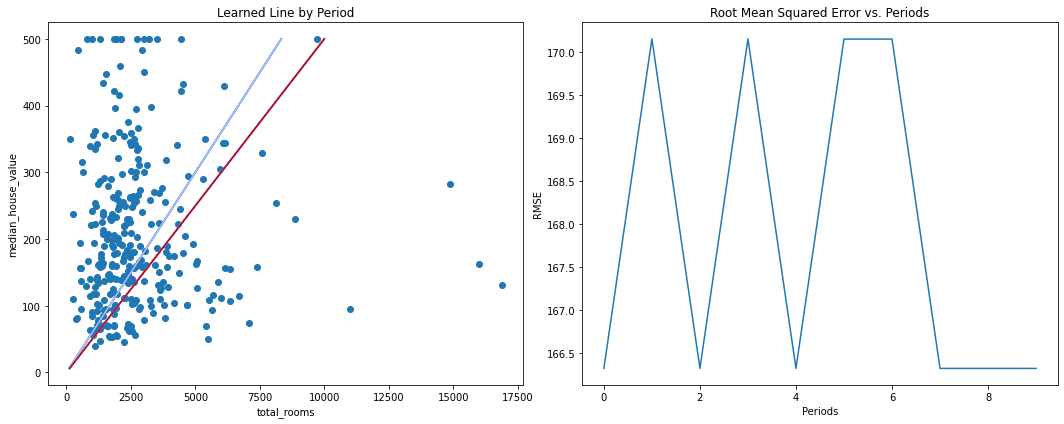

In [33]:
train_model(
    learning_rate=0.001,
    steps=100,
    batch_size=100
)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.44
  period 03 : 195.33
  period 04 : 187.55
  period 05 : 180.53
  period 06 : 176.10
  period 07 : 172.26
  period 08 : 169.60
  period 09 : 167.70
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,114.2,207.3
std,94.2,116.0
min,0.1,15.0
25%,63.2,119.4
50%,91.9,180.4
75%,136.1,265.0
max,1638.9,500.0


Final RMSE (on training data): 167.70


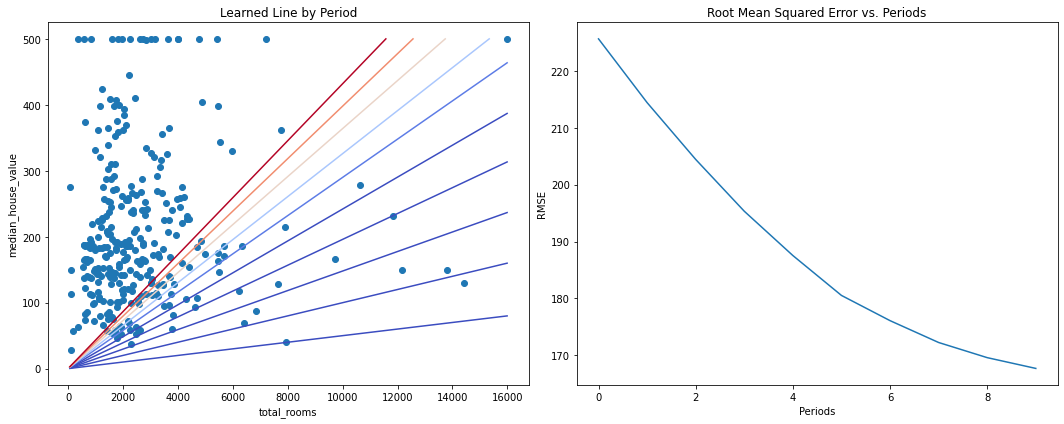

In [34]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

 Il ne s'agit là que d'une configuration parmi d'autres ; d'autres combinaisons de paramètres peuvent également donner de bons résultats. Notez que le but de cet exercice n'est pas de trouver le paramètre *optimal*, mais bien de vous aider à percevoir en quoi le réglage de la configuration du modèle affecte la qualité de prédiction.

 ### Existe-t-il une méthode heuristique standard en matière de réglage de modèle ?

Il s'agit là d'une question courante. En bref, on peut dire que les effets des différents hyperparamètres dépendent des données. Il n'existe donc pas de règles absolues. Vous devez effectuer des tests sur les données !

Cela étant dit, voici quelques règles empiriques qui peuvent s'avérer utiles :

 * L'erreur d'apprentissage doit diminuer régulièrement, selon une pente abrupte dans un premier temps, pour finalement se stabiliser à mesure que l'apprentissage converge.
 * Si l'apprentissage n'a pas convergé, essayez de l'exécuter plus longtemps.
 * Si l'erreur d'apprentissage diminue trop lentement, augmenter le taux d'apprentissage permettra peut-être d'accélérer la diminution.
   * Cependant, il arrive parfois que l'inverse se produise si le taux d'apprentissage est trop élevé.
 * Si l'erreur d'apprentissage varie sensiblement, essayez de diminuer le taux d'apprentissage.
   * Une bonne méthode consiste généralement à diminuer le taux d'apprentissage tout en augmentant le nombre de pas ou la taille du lot.
 * Des lots de très petite taille peuvent également entraîner une instabilité. Commencez par des valeurs telles que 100 ou 1 000, et continuez à réduire la taille jusqu'à ce que vous constatiez une dégradation.

Pour rappel, vous ne devez pas suivre à la lettre ces règles empiriques, car les effets dépendent des données. Vous devez toujours essayer une méthode et vérifier ensuite le résultat.

 ## Tâche 2 : Essayer une autre caractéristique

Voyons s'il est possible d'obtenir un meilleur résultat en remplaçant la caractéristique `total_rooms` par `population`.

Ne consacrez pas plus de cinq minutes à cette tâche.

Training model...
RMSE (on training data):
  period 00 : 220.00
  period 01 : 204.67
  period 02 : 192.08
  period 03 : 182.78
  period 04 : 179.00
  period 05 : 176.72
  period 06 : 175.91
  period 07 : 176.65
  period 08 : 176.23
  period 09 : 176.23
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,132.7,207.3
std,106.6,116.0
min,0.3,15.0
25%,73.4,119.4
50%,108.4,180.4
75%,159.8,265.0
max,3313.2,500.0


Final RMSE (on training data): 176.23


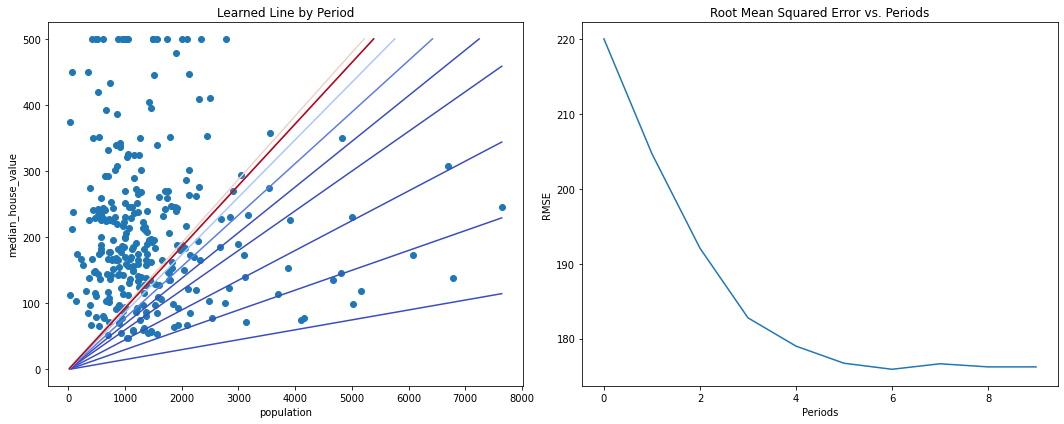

In [37]:
train_model(
    learning_rate=0.0003,
    steps=100,
    batch_size=20,
    input_feature="population"
)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 204.86
  period 03 : 196.59
  period 04 : 189.94
  period 05 : 184.45
  period 06 : 180.67
  period 07 : 178.24
  period 08 : 176.60
  period 09 : 176.07
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,118.7,207.3
std,95.3,116.0
min,0.2,15.0
25%,65.6,119.4
50%,96.9,180.4
75%,142.9,265.0
max,2962.1,500.0


Final RMSE (on training data): 176.07


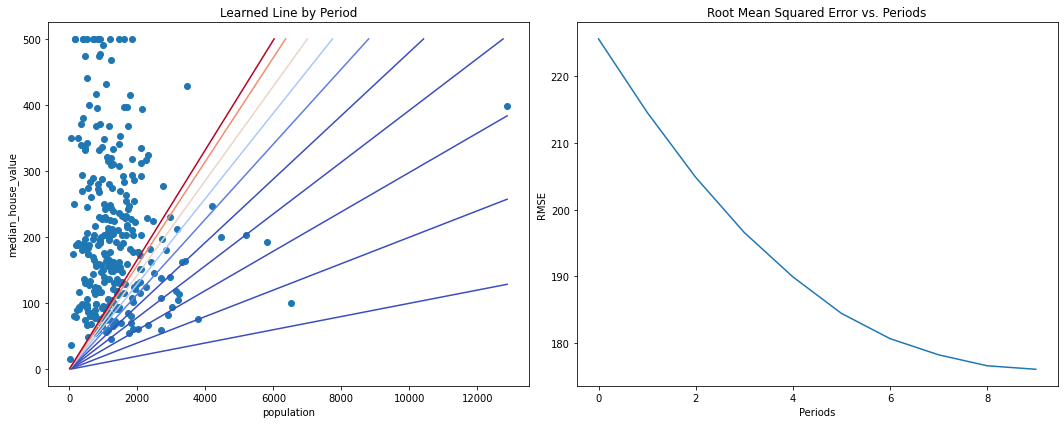

In [38]:
train_model(
    learning_rate=0.00002,
    steps=1000,
    batch_size=5,
    input_feature="population"
)